2.1. gán nhãn ảnh 

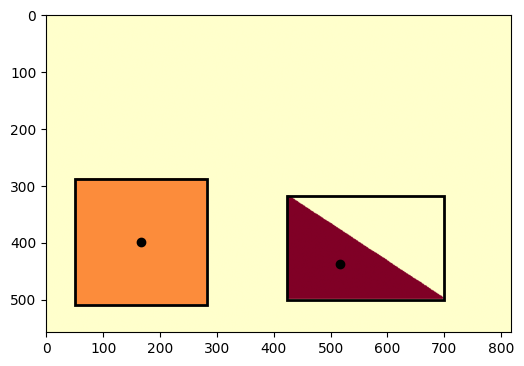

In [24]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh và chuyển sang ảnh mức xám
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

# Ngưỡng Otsu
thres = threshold_otsu(a)
b = a > thres

# Gán nhãn cho từng vùng đối tượng
c = label(b)
cl = Image.fromarray(c.astype(np.uint8))
iio.imwrite('geometric.png', cl)

# Tính toán thuộc tính vùng
properties = ['Area', 'Centroid', 'BoundingBox']
d = regionprops(c)

# Vẽ kết quả
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')

for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr
    # Vẽ bounding box
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    # Vẽ centroid
    cy, cx = i['Centroid']
    ax.plot(cx, cy, 'ko')  # chấm đen tại centroid

plt.show()


2.2.	Dò tìm cạnh theo chiều dọc

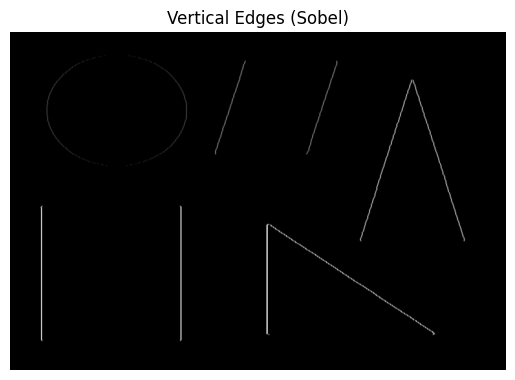

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh và chuyển sang grayscale
img = cv2.imread('geometric.png', cv2.IMREAD_GRAYSCALE)

# Áp dụng Sobel theo chiều dọc (dx=1, dy=0)
sobel_vertical = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

# Chuyển sang dạng ảnh 8-bit để hiển thị
abs_sobel_vertical = cv2.convertScaleAbs(sobel_vertical)

# Hiển thị kết quả
plt.imshow(abs_sobel_vertical, cmap='gray')
plt.title('Vertical Edges (Sobel)')
plt.axis('off')
plt.show()


2.3.	Dò tìm cạnh với Sobel Filter

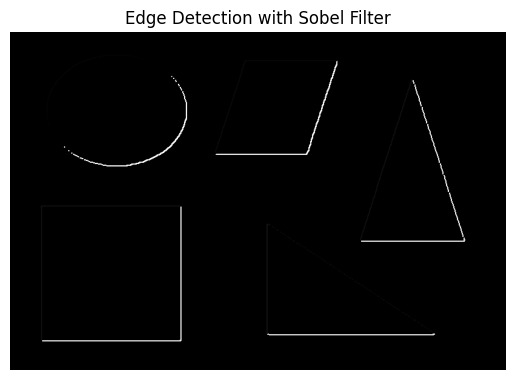

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Đọc ảnh và chuyển sang mảng numpy mức xám
img = Image.open('geometric.png').convert('L')
img_np = np.array(img)

# Áp dụng Sobel filter theo hai chiều
sobel_vertical = ndimage.sobel(img_np, axis=0)   # Cạnh đứng
sobel_horizontal = ndimage.sobel(img_np, axis=1) # Cạnh ngang

# Tổng biên độ cạnh
edge_magnitude = np.abs(sobel_vertical) + np.abs(sobel_horizontal)

# Hiển thị kết quả
plt.imshow(edge_magnitude, cmap='gray')
plt.title('Edge Detection with Sobel Filter')
plt.axis('off')
plt.show()


2.4.	Xác định góc của đối tượng

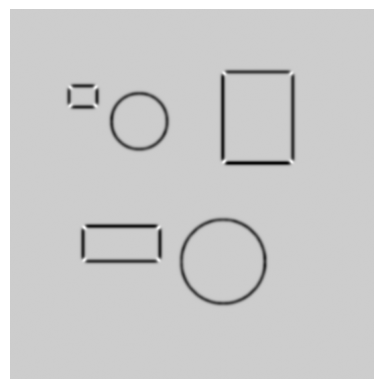

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, 0)
    y = nd.sobel(indata, 1)

    xl = x ** 2
    yl = y ** 2
    xy = x * y

    xl = nd.gaussian_filter(xl, 3)
    yl = nd.gaussian_filter(yl, 3)
    xy = nd.gaussian_filter(xy, 3)

    detC = xl * yl - xy**2
    trC = xl + yl
    R = detC - alpha * trC**2
    return R

# Mở ảnh và chuyển sang ảnh xám
img = Image.open('hinh2,4.png').convert('L')
gray = np.array(img).astype(np.float32)

# Áp dụng phát hiện góc
harris_response = Harris(gray)

# Bình thường hóa kết quả để dễ hiển thị
harris_norm = (harris_response - np.min(harris_response)) / (np.max(harris_response) - np.min(harris_response))

# Hiển thị ảnh
plt.imshow(harris_norm, cmap='gray')  # Nền xám
plt.axis('off')
plt.show()


2.5.1.	Dò tìm đường thẳng trong ảnh

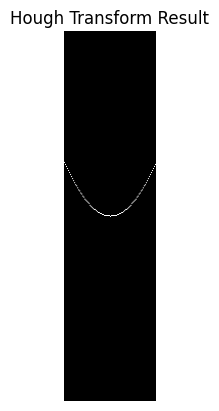

In [4]:
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V * V + H * H))
    ho = np.zeros((R, 90), float)  # Hough space

    w = data.copy()
    ok = 1

    theta = np.arange(90) / 180.0 * np.pi
    tp = np.arange(90).astype(float)

    while ok:
        mx = w.max()
        if mx < gamma:
            ok = 0
        else:
            v, h = divmod(w.argmax(), H)
            y = V - v
            x = h
            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                if 0 <= rh[i] < R and 0 <= tp[i] < 90:
                    ho[int(rh[i]), int(tp[i])] += mx
            w[v, h] = 0

    return ho

# Tạo ảnh đầu vào 256x256, điểm trắng ở trung tâm
data = np.zeros((256, 256))
data[128, 128] = 1

# Gọi hàm Hough
bmg = LineHough(data, 0.5)

# Hiển thị kết quả
plt.imshow(bmg, cmap='gray')
plt.title('Hough Transform Result')
plt.axis('off')
plt.show()


2.5.2.	Dò tìm đường tròn trong ảnh

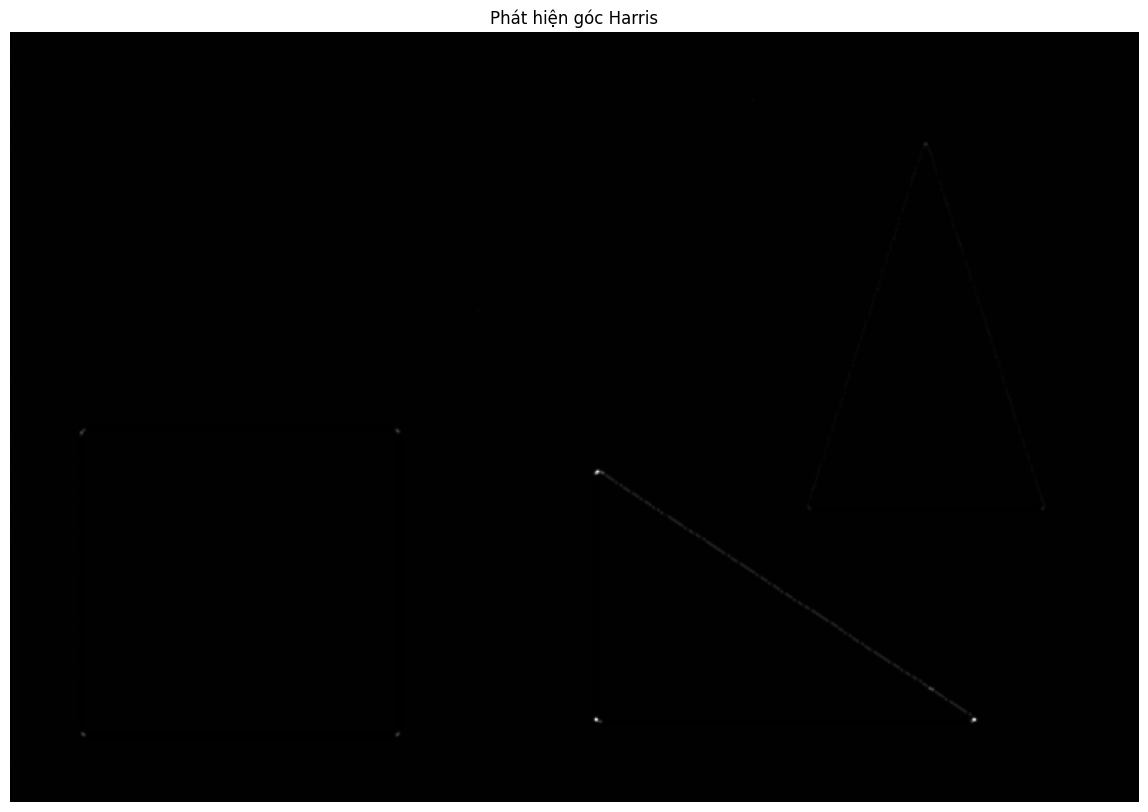

In [12]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

# Đọc ảnh
data = iio.imread('bird.png')
# Phát hiện góc Harris
corner_img = corner_harris(image_gray, k=0.001)

# Chuẩn hóa để hiển thị
corner_img = (corner_img - np.min(corner_img)) / (np.max(corner_img) - np.min(corner_img))

# Hiển thị kết quả
plt.figure(figsize=(20, 10))
plt.imshow(corner_img, cmap='gray')
plt.axis('off')
plt.title('Phát hiện góc Harris')
plt.show()


2.6.	Image matching

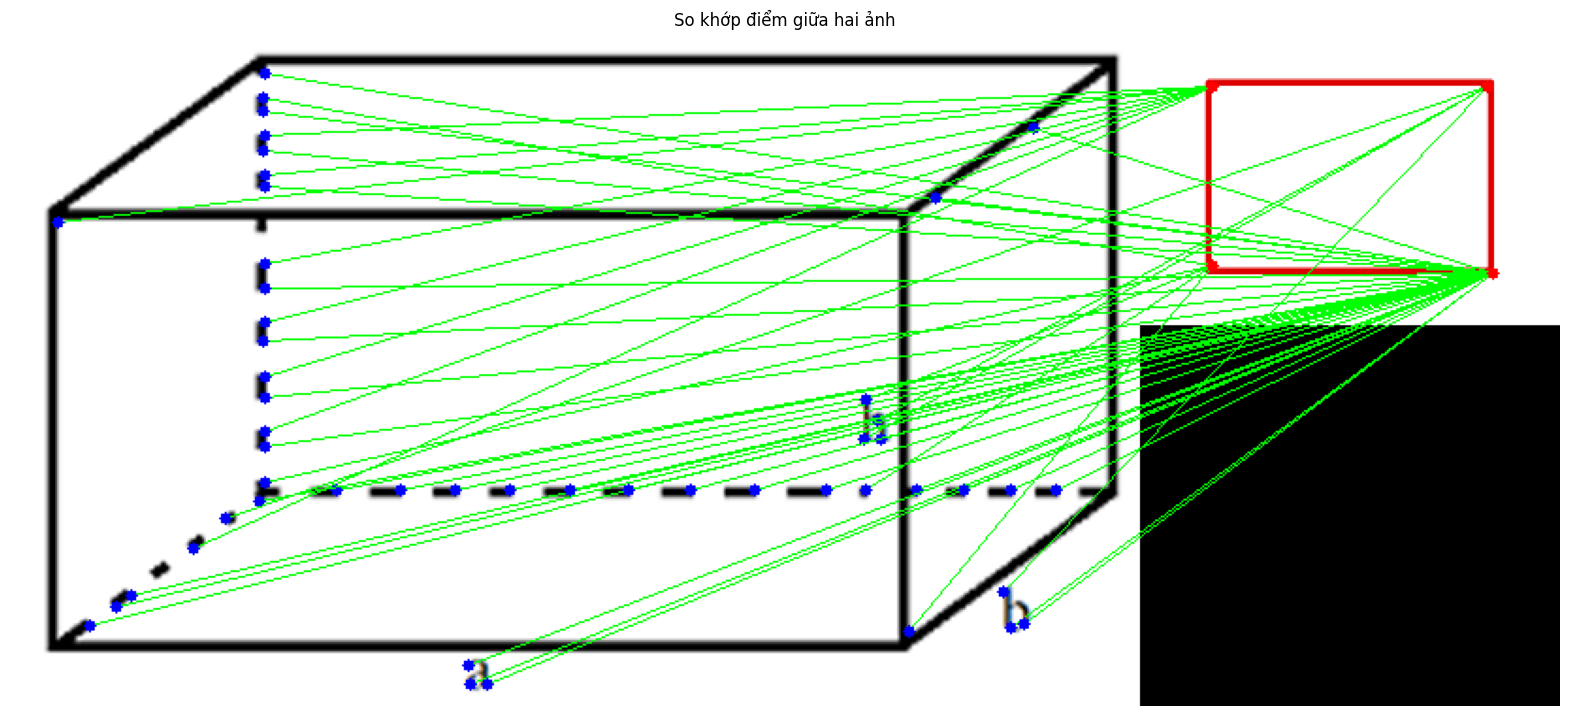

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris, corner_peaks
from skimage.color import rgb2gray
from skimage.util import img_as_float

# === 1. Load và chuyển ảnh sang ảnh xám ===
img1 = cv2.imread('image1.png')  # thay bằng ảnh thật của bạn
img2 = cv2.imread('image2.png')

gray1 = img_as_float(rgb2gray(img1))
gray2 = img_as_float(rgb2gray(img2))

# === 2. Phát hiện góc Harris ===
harris1 = corner_harris(gray1)
harris2 = corner_harris(gray2)

keypoints1 = corner_peaks(harris1, min_distance=5, threshold_rel=0.01)
keypoints2 = corner_peaks(harris2, min_distance=5, threshold_rel=0.01)

# === 3. Trích đặc trưng cục bộ (patch 11x11) quanh mỗi điểm ===
def extract_descriptors(image, keypoints, patch_size=11):
    half = patch_size // 2
    descriptors = []
    valid_points = []
    for y, x in keypoints:
        if y - half >= 0 and y + half < image.shape[0] and x - half >= 0 and x + half < image.shape[1]:
            patch = image[y - half:y + half + 1, x - half:x + half + 1]
            descriptors.append(patch.flatten())
            valid_points.append([y, x])
    return np.array(descriptors), np.array(valid_points)

desc1, keypoints1 = extract_descriptors(gray1, keypoints1)
desc2, keypoints2 = extract_descriptors(gray2, keypoints2)

# === 4. Tính khoảng cách Euclidean và tìm điểm khớp ===
matches = []
for i in range(len(desc1)):
    distances = np.linalg.norm(desc2 - desc1[i], axis=1)
    min_idx = np.argmin(distances)
    matches.append((i, min_idx, distances[min_idx]))

# === 5. Chọn các cặp khớp tốt nhất ===
matches = sorted(matches, key=lambda x: x[2])[:50]

# === 6. Hiển thị ảnh ghép và các cặp điểm tương đồng ===
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
result = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
result[:h1, :w1] = img1
result[:h2, w1:] = img2

for i1, i2, _ in matches:
    pt1 = keypoints1[i1][::-1]  # (x, y)
    pt2 = keypoints2[i2][::-1] + np.array([w1, 0])  # offset x
    cv2.line(result, tuple(pt1), tuple(pt2), (0, 255, 0), 1)
    cv2.circle(result, tuple(pt1), 3, (255, 0, 0), -1)
    cv2.circle(result, tuple(pt2), 3, (0, 0, 255), -1)

plt.figure(figsize=(20, 10))
plt.imshow(result[..., ::-1])  # chuyển BGR → RGB
plt.axis('off')
plt.title('So khớp điểm giữa hai ảnh')
plt.show()
